<a href="https://colab.research.google.com/github/comojin1994/VGG/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd ./drive/My\ Drive/Deep_learning/Paper_implementation/VGG
!ls

/content/drive/My Drive/Deep_learning/Paper_implementation/VGG
Evaluate.ipynb	model.py  __pycache__  Training.ipynb  VGG16  VGG19


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import os, math
import tensorflow_datasets as tfds
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from model import VGG16, VGG19
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

### Hyperparameter

In [0]:
EPOCHS = 100
batch_size = 32
input_shape = (batch_size, 32, 32 ,3)
num_classes = 10
learning_rate = 0.001
initial_epoch = 0

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']

### Load Data

In [6]:
(train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()
train_x.shape, train_y.shape, test_x.shape, test_y.shape

170500096/170498071 [==============================] - 11s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    dtype=tf.float32
)
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
    dtype=tf.float32
)

train_generator = train_datagen.flow(train_x, train_y, batch_size=batch_size)
validation_generator = validation_datagen.flow(train_x, train_y, batch_size=batch_size)

### Callbacks

In [0]:
# Tensorboard
logdir = os.path.join('VGG19/logs', datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard = tf.keras.callbacks.TensorBoard(
      logdir,
      histogram_freq=1,
      write_graph=True,
      write_images=True
)

# Learning rate scheduler
def scheduler(epoch):
    if epoch < 10: return 0.001
    else: return 0.001 * math.exp(0.1 * (10 - epoch))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# checkpoint
ckpt_dir = 'VGG19/checkpoints/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
      ckpt_dir,
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True
)

# EarlyStop
earlystop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=7, verbose=1)

callbacks = [tensorboard, learning_rate_scheduler, checkpoint, earlystop]

### Load and Compile Model

In [0]:
model = VGG19()
model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics)

# Load Weigth
if initial_epoch > 1:
    model.load_weights(ckpt_dir)

### Tenosorboard

In [11]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-03-13 05:58:06--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.95.127.176, 34.238.36.128, 52.7.103.227, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.95.127.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.05MB/s    in 2.2s    

2020-03-13 05:58:09 (6.05 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [12]:
get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(logdir))
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c8bf62d4.ngrok.io


### Training

In [13]:
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      callbacks=callbacks,
      validation_data=validation_generator,
      initial_epoch=initial_epoch,
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
)

  ...
    to  
  ['...']
Train for 1563 steps, validate for 1563 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
1562/1563 [============================>.] - ETA: 0s - loss: 2.1416 - accuracy: 0.1695
Epoch 00001: val_accuracy improved from -inf to 0.13832, saving model to VGG19/checkpoints/
1563/1563 [==============================] - 252s 161ms/step - loss: 2.1415 - accuracy: 0.1695 - val_loss: 2.3361 - val_accuracy: 0.1383

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.9594 - accuracy: 0.2157
Epoch 00002: val_accuracy improved from 0.13832 to 0.21134, saving model to VGG19/checkpoints/
1563/1563 [==============================] - 241s 154ms/step - loss: 1.9593 - accuracy: 0.2157 - val_loss: 1.9984 - val_accuracy: 0.2113

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/100
1562/1563 [============================>.] - ETA: 0

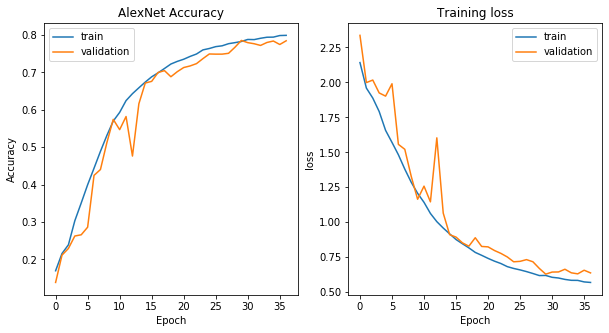

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()